<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrame API

`dask.dataframe` API is the high-level collection that looks and feels like the pandas API, but for parallel and distributed workflows. At it's core, the `dask.dataframe` module implements a "blocked parallel" `DataFrame` object that. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrame`s separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg"
     width="30%"
     alt="Dask DataFrame is compsed of pandas DataFrames"/>

The term "Dask DataFrame" is slightly overloaded. Depending on the context, it can refer to the API or the DataFrame object (data structure composed on multiple pandas DataFrames shown above). To avoid confusion, throughout this notebook:
- `dask.dataframe` (note the all lowercase) refers to the API, and
- `dask.dataframe.DataFrame` or simply `DataFrame` (note the CamelCase) refers to the object.

## When to use `dask.dataframe`

pandas is great for tabular datasets that fit in memory. A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Here "size of dataset" means dataset size on _the disk_.

Dask becomes useful when the datasets exceed the above rule.

In this notebook, you will be working with the New York City Airline data. This dataset is only ~200MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to  datasets **much** larger than memory.

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

## Create datasets

Create the datasets you will be using in this notebook:

In [1]:
%run prep.py -d flights

## Set up your local cluster

Create a local Dask cluster and connect it to the client. Don't worry about this bit of code for now, you will learn more in the Distributed notebook.

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 6.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45365,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 6.78 GiB
Comm: tcp://127.0.0.1:34995,Total threads: 1
Dashboard: http://127.0.0.1:34427/status,Memory: 1.70 GiB
Nanny: tcp://127.0.0.1:39043,


### Dask Diagnostic Dashboard

Dask Distributed provides a useful Dashboard to visualize the state of your cluster and computations.

If you're on **JupyterLab or Binder**, you can use the [Dask JupyterLab extension](https://github.com/dask/dask-labextension) (which should be already installed in your environment) to open the dashboard plots:
* Click on the Dask logo in the left sidebar
* Click on the magnifying glass icon, which will automatically connect to the active dashboard (if that doesn't work, you can type/paste the dashboard link http://127.0.0.1:8787 in the field)
* Click on **"Task Stream"**, **"Progress Bar"**, and **"Worker Memory"**, which will open these plots in new tabs
* Re-organize the tabs to suit your workflow!

Alternatively, click on the dashboard link displayed in the Client details above: http://127.0.0.1:8787/status. It will open a new browser tab with the Dashboard.

## Reading and working with datasets

Let's read an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

The following filename includes a glob pattern `*`, so all files in the path matching that pattern will be read into the same Dask `DataFrame`.

In [3]:
import os
import dask

By convention, we import `dask.dataframe` as `dd`, and call the corresponding Dask DataFrame `ddf`.

In [4]:
import dask.dataframe as dd

In [5]:
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                  parse_dates={'Date': [0, 1, 2]})

In [6]:
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask has not loaded the data yet, it has:
- investigated the input path and found that there are ten matching files
- intelligently created a set of jobs for each chunk -- one per original CSV file in this case

Notice that the representation of the DataFrame object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

### Lazy Evaluation

Most Dask Collections, including Dask `DataFrame` are evaluated lazily, which means Dask constructs the logic (called task graph) of your computation immediately but "evaluates" them  only when necessary. You can view this task graph using `.visualize()`.

You will learn more about this in the Delayed notebook, but for now, note that we need to call `.compute()` to trigger actual computations.

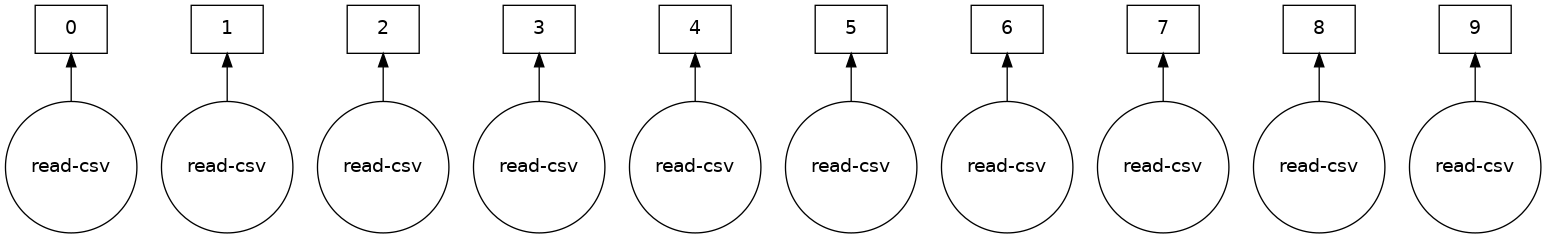

In [7]:
ddf.visualize()

Some functions like `len` and `head` also trigger a computation. Specifically, calling `len` will:
- load actual data, (that is, load each file into a pandas DataFrame)
- then apply the corresponding functions to each pandas DataFrame (also known as a partition)
- combine the subtotals to give you the final grand total

In [8]:
# load and count number of rows
len(ddf)

9990

You can view the start and end of the data as you would in pandas:

In [9]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


```python
ddf.tail()

# ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

# +----------------+---------+----------+
# | Column         | Found   | Expected |
# +----------------+---------+----------+
# | CRSElapsedTime | float64 | int64    |
# | TailNum        | object  | float64  |
# +----------------+---------+----------+

# The following columns also raised exceptions on conversion:

# - TailNum
#   ValueError("could not convert string to float: 'N54711'")

# Usually this is due to dask's dtype inference failing, and
# *may* be fixed by specifying dtypes manually by adding:

# dtype={'CRSElapsedTime': 'float64',
#        'TailNum': 'object'}

# to the call to `read_csv`/`read_table`.

```

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually `floats` (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns. 

In [10]:
ddf = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [11]:
ddf.tail()  # now works

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
994,1999-01-25,1,632.0,635,803.0,817,CO,437,N27213,91.0,...,68.0,-14.0,-3.0,EWR,RDU,416.0,4.0,19.0,False,0
995,1999-01-26,2,632.0,635,751.0,817,CO,437,N16217,79.0,...,62.0,-26.0,-3.0,EWR,RDU,416.0,3.0,14.0,False,0
996,1999-01-27,3,631.0,635,756.0,817,CO,437,N12216,85.0,...,66.0,-21.0,-4.0,EWR,RDU,416.0,4.0,15.0,False,0
997,1999-01-28,4,629.0,635,803.0,817,CO,437,N26210,94.0,...,69.0,-14.0,-6.0,EWR,RDU,416.0,5.0,20.0,False,0
998,1999-01-29,5,632.0,635,802.0,817,CO,437,N12225,90.0,...,67.0,-15.0,-3.0,EWR,RDU,416.0,5.0,18.0,False,0


### Reading from remote storage

If you're thinking about distributed computing, your data is probably stored remotely on services (like Amazon's S3 or Google's cloud storage) and is in a friendlier format (like Parquet). Dask can read data in various formats directly from these remote locations **lazily** and **in parallel**.

Here's how you can read the NYC taxi cab data from Amazon S3:

```python
ddf = dd.read_parquet(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.parquet",
)
```

You can also leverage Parquet-specific optimizations like column selection and metadata handling, learn more in [the Dask documentation on working with Parquet files](https://docs.dask.org/en/stable/dataframe-parquet.html).

## Computations with `dask.dataframe`

Let's compute the maximum of the `DepDelay` column.

With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums.

```python
import pandas as pd

files = os.listdir(os.path.join('data', 'nycflights'))

maxes = []

for fn in file:
    df = pd.read_csv(os.path.join('data', 'nycflights', file))
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

`dask.dataframe` lets us write pandas-like code, that operates on larger-than-memory datasets in parallel.

In [12]:
%%time
ddf.DepDelay.max().compute()

CPU times: user 30.5 ms, sys: 3.79 ms, total: 34.2 ms
Wall time: 123 ms


409.0

This creates the lazy computation for us and then runs it.  

**Note:** Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. This means you can handle datasets that are larger than memory but, repeated computations will have to load all of the data in each time. (Run the code above again, is it faster or slower than you would expect?)

You can view the underlying task graph using the `.visualize` method:

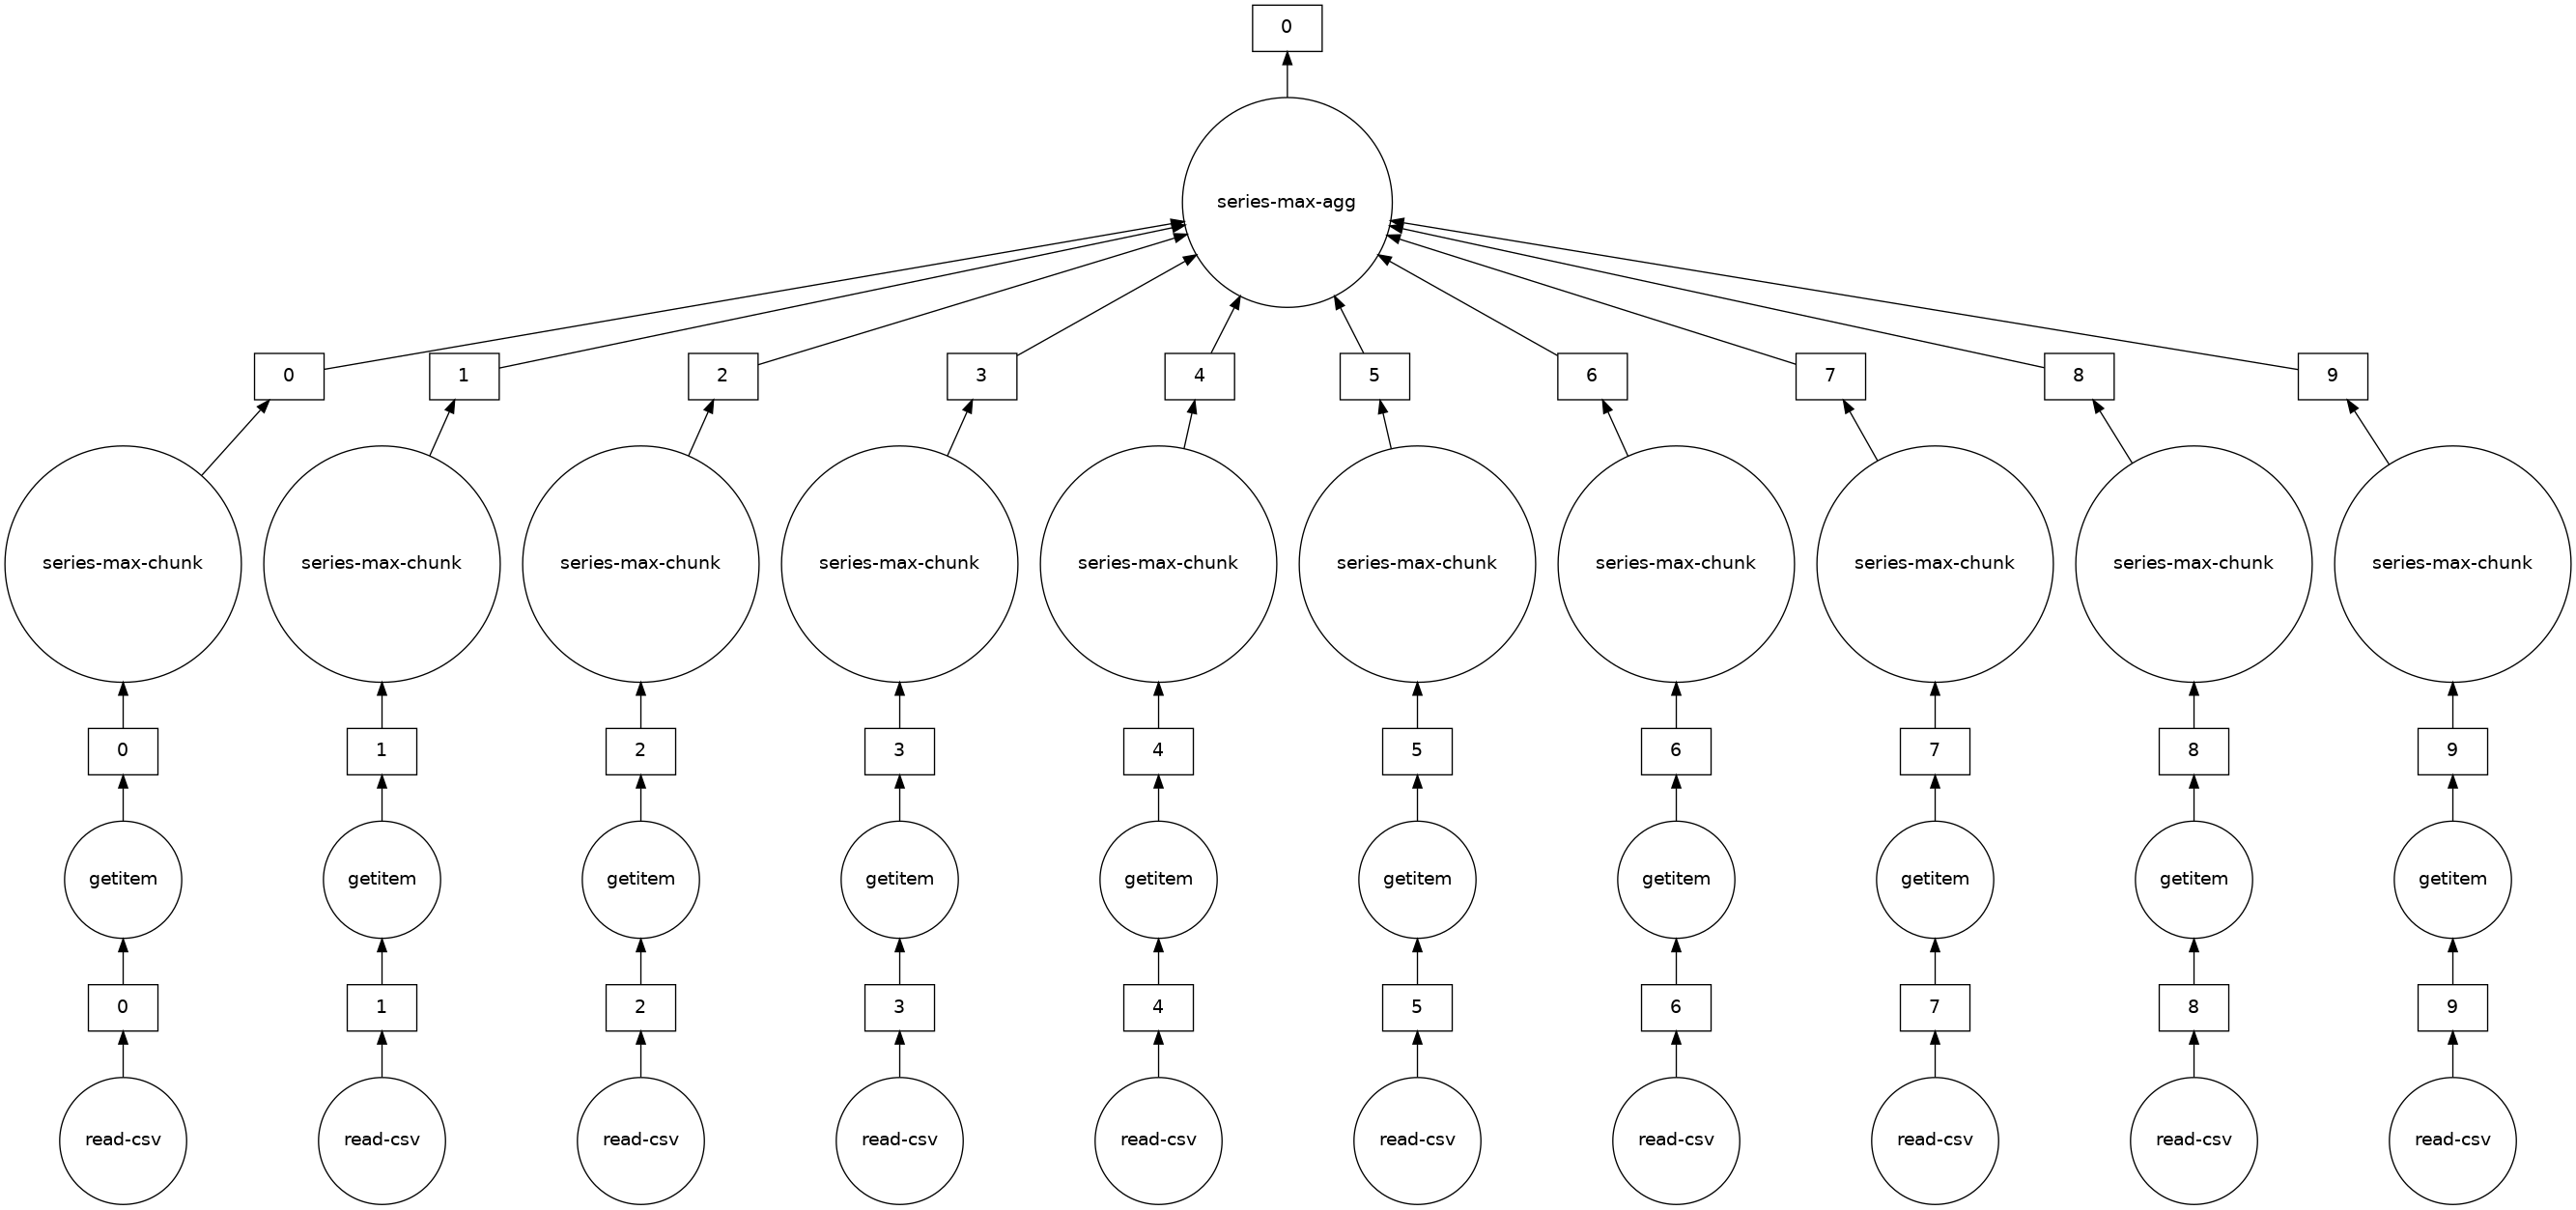

In [13]:
# notice the parallelism
ddf.DepDelay.max().visualize()

## Exercises

In this section you will do a few `dask.dataframe` computations. If you are comfortable with pandas then these should be familiar. You will have to think about when to call `compute`.

### 1. How many rows are in our dataset?

If you aren't familiar with pandas, how would you check how many records are in a list of tuples?

In [14]:
# Your code here

In [15]:
len(ddf)

9990

### 2. In total, how many non-canceled flights were taken?

With pandas, you would use [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [16]:
# Your code here

In [17]:
len(ddf[~ddf.Cancelled])

9383

### 3. In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [18]:
# Your code here

In [19]:
ddf[~ddf.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    4132
JFK    1085
LGA    4166
Name: Origin, dtype: int64

### 4. What was the average departure delay from each airport?

In [20]:
# Your code here

In [21]:
ddf.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    12.500968
JFK    17.053456
LGA    10.169227
Name: DepDelay, dtype: float64

### 5. What day of the week has the worst average departure delay?

In [22]:
# Your code here

In [23]:
ddf.groupby("DayOfWeek").DepDelay.mean().idxmax().compute()

5

### 6. Let's say the distance column is erroneous and you need to add 1 to all values, how would you do this?

In [24]:
# Your code here

In [25]:
ddf["Distance"].apply(lambda x: x+1).compute() # don't worry about the warning, we'll discuss in the next sections

/usr/share/miniconda3/envs/dask-tutorial/lib/python3.9/site-packages/dask/dataframe/core.py:3974: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Distance', 'float64'))

  warnings.warn(meta_warning(meta))


0      320.0
1      320.0
2      320.0
3      320.0
4      320.0
       ...  
994    417.0
995    417.0
996    417.0
997    417.0
998    417.0
Name: Distance, Length: 9990, dtype: float64

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If you compute them with two calls to compute, there is no sharing of intermediate computations.

In [26]:
non_canceled = ddf[~ddf.Cancelled]
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

In [27]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 112 ms, sys: 8.51 ms, total: 121 ms
Wall time: 330 ms


### `dask.compute`

But let's try by passing both to a single `compute` call.

In [28]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 76.6 ms, sys: 5.07 ms, total: 81.6 ms
Wall time: 197 ms


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (you might want to use `filename='graph.pdf'` to save the graph to disk so that you can zoom in more easily):

In [29]:
dask.visualize(mean_delay, std_delay, engine="cytoscape")

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

### `persit`

While using a distributed scheduler (you will learn more about schedulers in the upcoming notebooks), which is the case in this notebook, you can keep some _data that you want to use often_ in the _distributed memory_. 

`persist` computes the "Futures" ( and stores it in the same structure as your output. You can use persist with any data or computation that fits in memory.

If you want to analyze data only for non-canceled flights departing from JFK airport, you can either have two compute calls like in the previous section:

In [30]:
non_cancelled = ddf[~ddf.Cancelled]
ddf_jfk = non_cancelled[non_cancelled.Origin == "JFK"]

In [31]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.sum().compute()

CPU times: user 117 ms, sys: 33.5 ms, total: 150 ms
Wall time: 369 ms


18503.0

Or, consider persisting that subset of data in memory.

See the "Graph" dashboard plot, the red squares indicate persisted data stored as Futures in memory. You will also notice an increase in Worker Memory (another dashboard plot) consumption.

In [32]:
ddf_jfk = ddf_jfk.persist() # returns back control immediately

In [33]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.std().compute()

CPU times: user 110 ms, sys: 5.66 ms, total: 116 ms
Wall time: 266 ms


36.85799641792652

Analyses on this persisted data is faster because we are not repeating the loading and selecting (non-canceled, JFK departure) operations.

## Custom code with Dask DataFrame

`dask.dataframe` only covers a small but well-used portion of the pandas API.

This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel, e.g, sorting.

Additionally, some important operations like `set_index` work, but are slower than in pandas because they include substantial shuffling of data, and may write out to disk.

**So, what if you want to use some custom functions that aren't (or can't be) implemented for Dask DataFrame yet?**

You can open an issue on the [Dask issue tracker](https://github.com/dask/dask/issues) to check how feasible the function could be to implement, and you can consider contributing this function to Dask.

If it's a custom function or tricky to implement, `dask.dataframe` provides a few methods to make applying custom functions to Dask DataFrames easier:

- [`map_partitions`](https://docs.dask.org/en/latest/generated/dask.dataframe.DataFrame.map_partitions.html): to use a function on each partition (each pandas DataFrame) of the Dask DataFrame
- [`map_overlap`](https://docs.dask.org/en/latest/generated/dask.dataframe.rolling.map_overlap.html): to use a function on each partition (each pandas DataFrame) of the Dask DataFrame, with some overlap between partitions
- [`reduction`](https://docs.dask.org/en/latest/generated/dask.dataframe.Series.reduction.html): for custom row-wise reduction operations.

Let's take a quick look at the `map_partitions()` function:

In [34]:
help(ddf.map_partitions)

Help on method map_partitions in module dask.dataframe.core:

map_partitions(func, *args, **kwargs) method of dask.dataframe.core.DataFrame instance
    Apply Python function on each DataFrame partition.
    
    Note that the index and divisions are assumed to remain unchanged.
    
    Parameters
    ----------
    func : function
        The function applied to each partition. If this function accepts
        the special ``partition_info`` keyword argument, it will receive
        information on the partition's relative location within the
        dataframe.
    args, kwargs :
        Positional and keyword arguments to pass to the function.
        Positional arguments are computed on a per-partition basis, while
        keyword arguments are shared across all partitions. The partition
        itself will be the first positional argument, with all other
        arguments passed *after*. Arguments can be ``Scalar``, ``Delayed``,
        or regular Python objects. DataFrame-like args

In [35]:
# TODO: update with df.a + df.b - df.c

def my_custom_function(df, parameter_a=True):
    # toy function just for demonstration
    if parameter_a:
        # do something with df
        return df
    return df

meta = ddf.head()

ddf = ddf.map_partitions(my_custom_function, True, meta=meta)

We suggest using Dask's `apply` and `map` functions when you can because they already use `map_partitions` internally.

Using the correct `meta` is important here, because your output will depend on it. A few notes about `meta`:
* Think of `meta` as a suggestion that Dask will while it is operating lazily and can not infer the output structure.
* The best way to specify `meta` is using a small pandas DataFrame and Series that match the structure of your final output.

## Close you local Dask Cluster

It's good practice to close any Dask cluster you create:

In [36]:
client.shutdown()

## Final thoughts

`dask.dataframe` operations use `pandas` operations internally. Generally, they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task. This is usually negligible.
2.  When pandas releases the GIL `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

**To reiterate**, in this tutorial you used a small dataset consisting of a few CSV files. This dataset is small enough that you would normally use pandas. We've chosen this size so that exercises finish quickly. `dask.dataframe` only really becomes meaningful for problems significantly larger than this, when pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler (you will learn about it later) allows the same `dask.dataframe` expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_parquet`, where the data is held on storage accessible to every worker node (e.g., amazon's S3), and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.